In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
path = '/home/alvaro/Escritorio/FIUBA/Programación/Organizacion de datos'
df= pd.read_csv(path + '/train.csv')
#Fuente: https://es.investing.com/currencies/usd-mxn-historical-data
#AGREGAR EL PATH CORRESPONDIENTE
path1 = '/home/alvaro/Descargas'
dolar= pd.read_csv(path1 + '/Datos históricos USD_MXN.csv')
dolar.columns = ["fecha", "last", "opening", "max", "min", "std"]
dolar.drop(["std", "opening", "opening", "max", "min"], axis=1 ,inplace=True)
#Paso a formato fecha correctamente y luego creo columnas mes y año
dolar['date'] = pd.to_datetime(dolar['fecha'], format="%b %Y")
dolar.drop(["fecha"], axis=1, inplace=True)
dolar.columns= ['price', "date"]
#El csv ponia los numeros con punto en vez de coma.
dolar['price'] = dolar['price'].replace(',', '.', regex=True).astype(float)
dolar["year"] = dolar.date.dt.year
dolar['month'] = dolar.date.dt.month
dolar.drop(["date"], axis=1, inplace=True)
df['fecha'] = pd.to_datetime(df['fecha'])
df['year'] = df['fecha'].dt.year
df['month']= df['fecha'].dt.month
#Agrego la columna precio en dolar por propiedad, en el dataframe original
newDf= pd.merge(df, dolar, on=['year', 'month'], how='left')
newDf["dollar_price"] = newDf.apply(lambda row: row["precio"]/row["price"], axis=1)
#Filtro dejando las cosas útiles.
#Para agregar una columna, se debe agregar aca y luego agregarla al merge
df = newDf.filter(["id", "tipodepropiedad", "habitaciones",'garages', 'banos', 'ciudad',
                   'provincia','metroscubiertos', 'metrostotales', 'idzona', 'fecha',
                   'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
                   'centroscomercialescercanos', 'dollar_price' ])
def asignarMetros(metroscubiertos, metrostotales):
    if (metroscubiertos != 0 and metrostotales == 0):
        return metroscubiertos
    else:
        return metrostotales
    
#Arreglando, no pueden haber propiedades con metros cubiertos pero sin metros totales
df['metrostotales'].fillna(0, inplace=True)
df['metrostotales'] = df.apply(lambda x: asignarMetros(x['metroscubiertos'],x['metrostotales']),axis=1)
df.head()
#Filtrando el garage, lotes, hospedaje, otros
filtroTerreno = df["tipodepropiedad"].isin(["Huerta", "Nave industrial", "Terreno", "Terreno comercial", 
                                            "Bodega comercial", "Terreno industrial"])
dfTerreno = df[filtroTerreno]
dfTerreno.tipodepropiedad.value_counts()
#Dropeo todos los terrenos que tienen habitaciones ya que si las tienen no serian terrenos.
dfTerreno = dfTerreno[dfTerreno["habitaciones"].isna()]
dfTerreno.tipodepropiedad.value_counts()
#Limpiando las propiedades tipo casa, no pueden no tener al menos una habitacion o baño y no pueden
#tener metros no cubiertos
filtro1 = df["tipodepropiedad"].isin(["Apartamento", "Casa", "Casa en condominio",
                                        "Casa uso de suelo", "Rancho", "Quinta Vacacional"])
dfCasas = df[filtro1]
dfCasas = dfCasas[np.isfinite(dfCasas['habitaciones'])]
dfCasas = dfCasas[np.isfinite(dfCasas['banos'])]
dfCasas = dfCasas[np.isfinite(dfCasas['metroscubiertos'])]
dfCasas.garages.fillna(0, inplace=True)
df = pd.merge(dfCasas, dfTerreno, on=['id', 'tipodepropiedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos'
                                      ,'ciudad','provincia','metrostotales','idzona','fecha', 'gimnasio','usosmultiples',
                                       'piscina','escuelascercanas','centroscomercialescercanos', 'dollar_price'], how='outer')

In [46]:
df.columns

Index(['id', 'tipodepropiedad', 'habitaciones', 'garages', 'banos', 'ciudad',
       'provincia', 'metroscubiertos', 'metrostotales', 'idzona', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'dollar_price'],
      dtype='object')

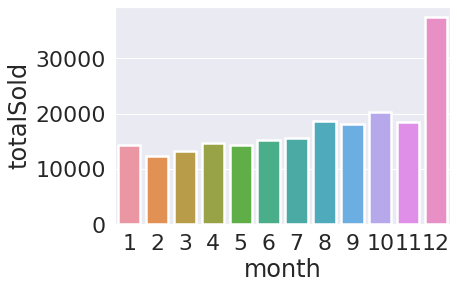

In [47]:
#Arranco 
df["year"] = df.fecha.dt.year
df['month'] = df.fecha.dt.month
grouped = df.groupby('month').agg({'year':'count'})
grouped.reset_index(inplace=True)
grouped.columns = ['month', 'totalSold']
#Cantidad de ventas por mes
sns.set(font_scale=2)
sns.barplot(x="month", y='totalSold',data=grouped, linewidth=2.5)

In [48]:
grouped = df.groupby(['month', 'year'])
forPlot = grouped.agg({'year':{'totalSold':'count'}})
#sns.relplot(x="year", col_wrap=5,y='dollar_price',kind='line',
#            data=df,hue='provincia',col='tipodepropiedad',height=3, linewidth=2.5)

forPlot.reset_index(inplace=True)

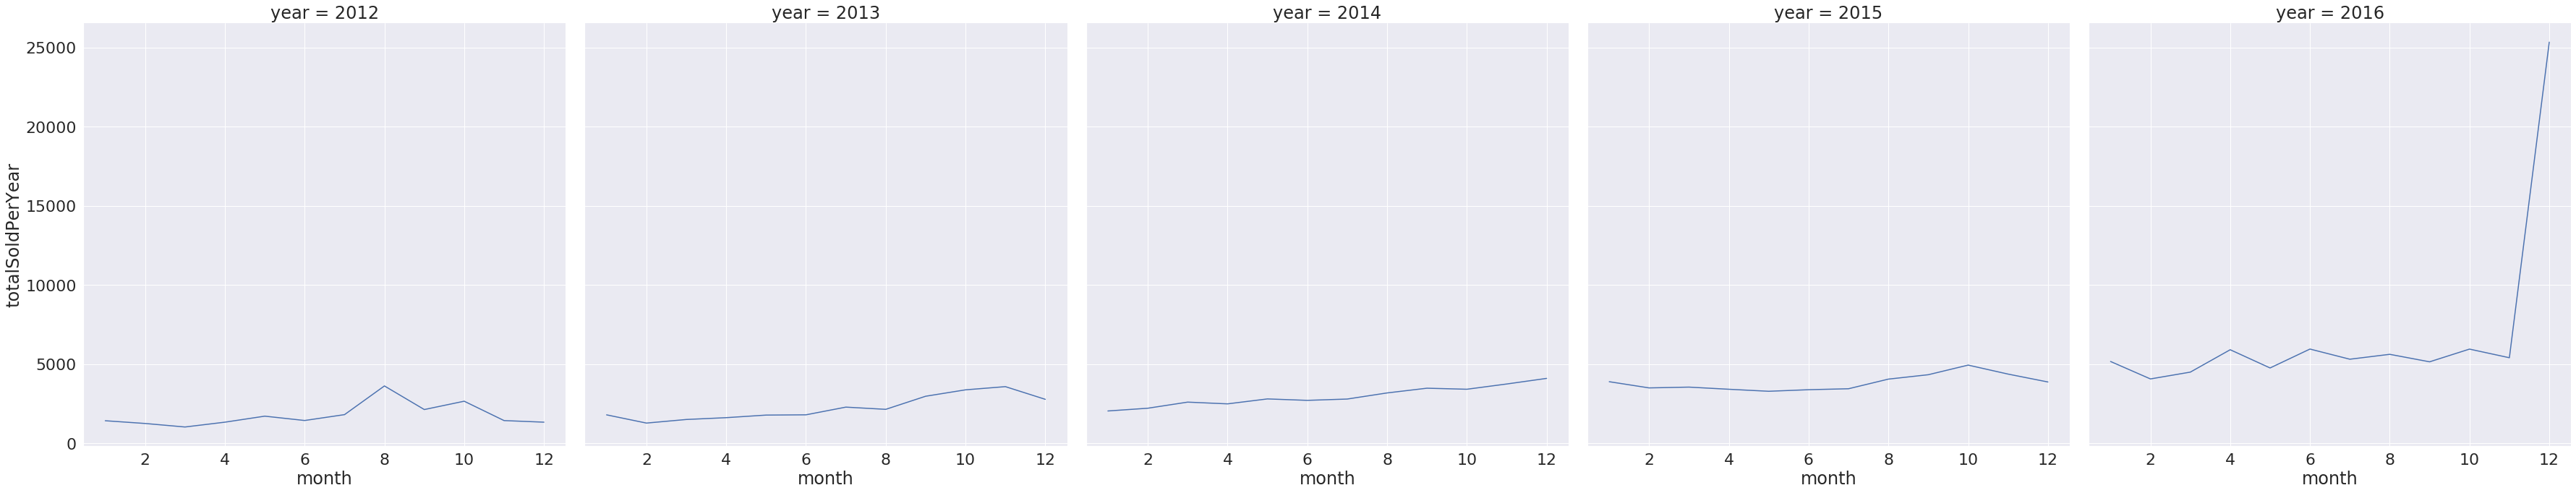

In [49]:
forPlot.columns = ['month', 'year', 'totalSoldPerYear']
sns.set(font_scale=2)
sns.relplot(x="month", col_wrap=5,y='totalSoldPerYear',kind='line',
            data=forPlot,col='year',height=10, aspect=1)

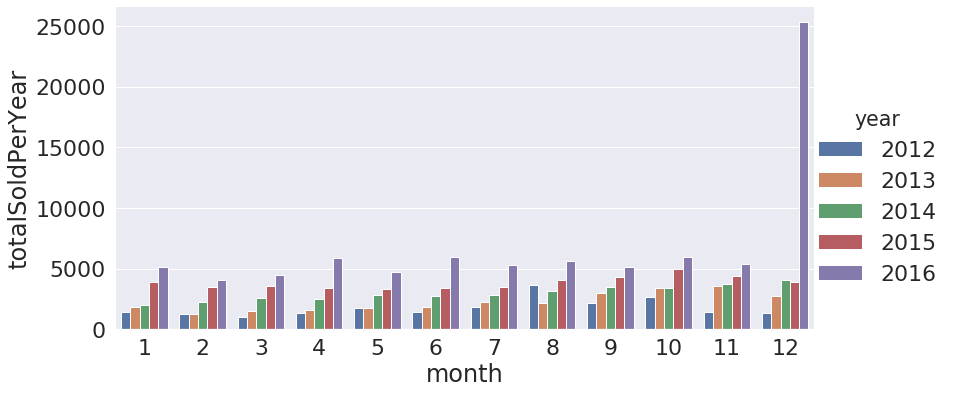

In [50]:
g = sns.catplot(x="month", y="totalSoldPerYear",
                 hue="year",
                 data=forPlot, kind="bar",
                 height=6, aspect=2);

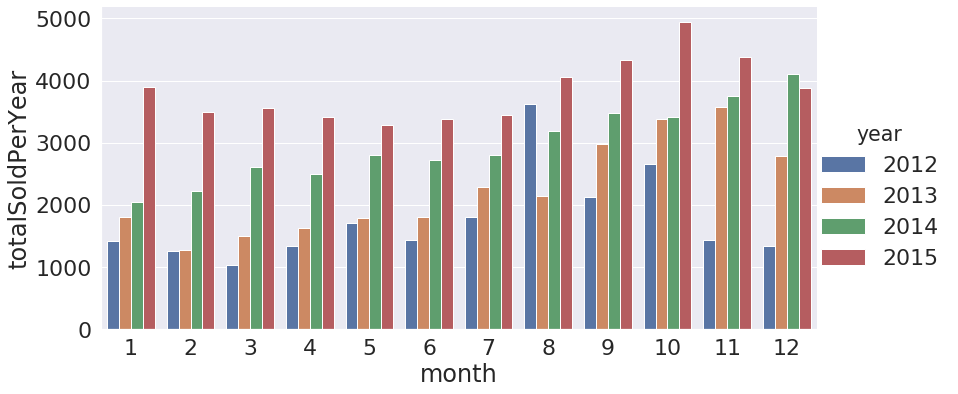

In [51]:
filtro = forPlot["year"].isin(["2012", "2013", "2014", "2015"])
forPlot1215= forPlot[filtro]
g = sns.catplot(x="month", y="totalSoldPerYear",
                 hue="year",
                 data=forPlot1215, kind="bar",
                 height=6, aspect=2);

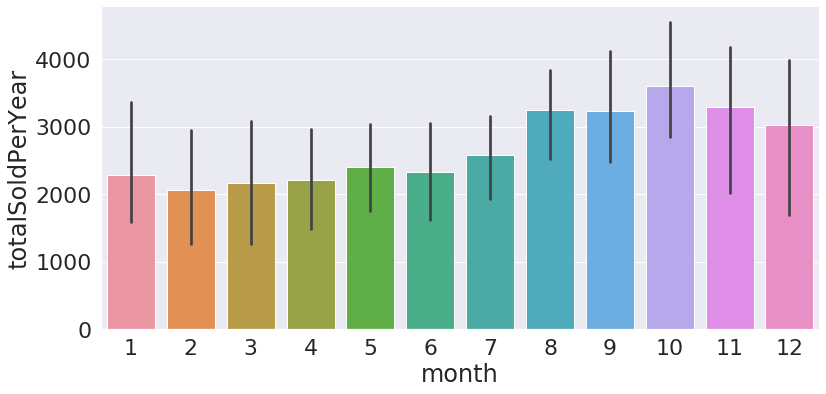

In [52]:
g = sns.catplot(x="month", y="totalSoldPerYear",
                 data=forPlot1215, kind="bar",
                 height=6, aspect=2);

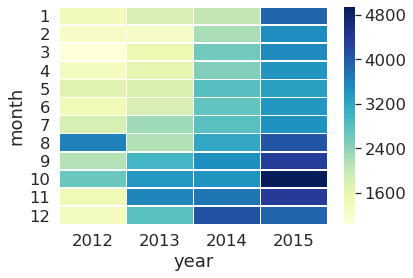

In [53]:
pivot = forPlot1215.pivot("month", "year", "totalSoldPerYear")
sns.set(font_scale=1.5)
ax = sns.heatmap(pivot, cmap="YlGnBu", linewidths=.5)

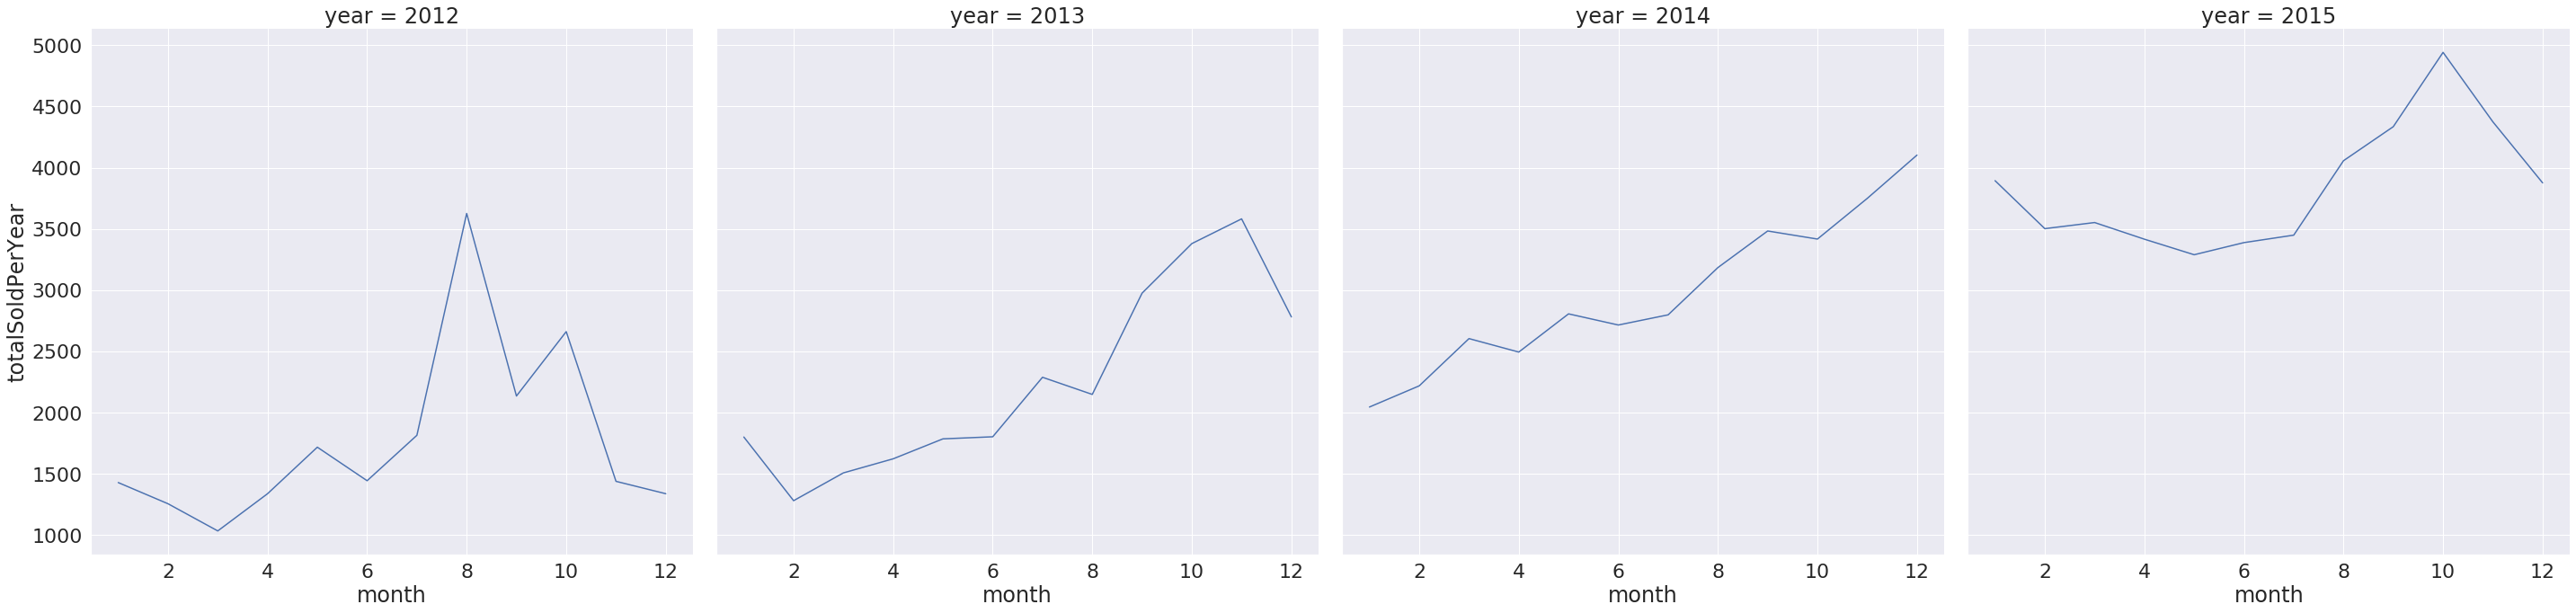

In [54]:
sns.set(font_scale=2)
sns.relplot(x="month", col_wrap=5,y='totalSoldPerYear',kind='line',
            data=forPlot1215,col='year',height=10, aspect=1)

In [55]:
dfProp = df.filter(["tipodepropiedad", "fecha"])
dfProp["year"] = dfProp["fecha"].dt.year
dfProp["month"] = dfProp["fecha"].dt.month
dfProp["day"] = dfProp["fecha"].dt.day
dfProp.drop("fecha", axis=1, inplace=True)

In [56]:
grouped = dfProp.groupby(["tipodepropiedad"])
agg = grouped.agg({"tipodepropiedad" : {"totalSold":"count"}})
agg

,tipodepropiedad
,totalSold
tipodepropiedad,
Apartamento,54955
Bodega comercial,1249
Casa,127228
Casa en condominio,17936
Casa uso de suelo,386
Huerta,13
Nave industrial,63
Quinta Vacacional,321


In [57]:
agg.reset_index(inplace=True)
agg.colums = ["tipodepropiedad", "totalSold"]

/home/alvaro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [58]:
grouped = dfProp.groupby(["tipodepropiedad", "year", "month"])
plot = grouped.agg({"tipodepropiedad":{"totalSold":"count"} })
plot

tipodepropiedad
                                    totalSold
tipodepropiedad    year month                
Apartamento        2012 1                 316
                        2                 294
                        3                 261
                        4                 315
                        5                 375
                        6                 352
                        7                 404
                        8                 824
                        9                 481
                        10                564
                        11                410
                        12                335
                   2013 1                 402
                        2                 353
                        3                 364
                        4                 370
                        5                 418
                        6                 487
                        7                 597
                        8                 531
                        9                 694
                        10                717
                        11                854
                        12                591
                   2014 1                 459
                        2                 541
                        3                 598
                        4                 732
                        5                 728
                        6                 740
...                                       ...
Terreno comercial  2015 9                  29
                        10                 71
                        11                 21
                        12                 27
                   2016 1                  54
                        2                  34
                        3                  25
                        4                  38
                        5                  20
                        6                  27
                        7                  21
                        8                  32
                        9                  20
                        10                 24
                        11                 19
                        12                 47
Terreno industrial 2014 3                   1
                   2015 1                   2
                        3                   1
                        9                   1
                        11                  1
                   2016 1                   1
                        2                   1
                        6                   3
                        7                   2
                        8                   1
                        9                   1
                        10                  3
                        11                  3
                        12                  7

[583 rows x 1 columns]

In [59]:
plot = plot.reset_index()
plot

,tipodepropiedad,year,month,tipodepropiedad
,,,,totalSold
0,Apartamento,2012,1,316
1,Apartamento,2012,2,294
2,Apartamento,2012,3,261
3,Apartamento,2012,4,315
4,Apartamento,2012,5,375
5,Apartamento,2012,6,352
6,Apartamento,2012,7,404
7,Apartamento,2012,8,824
8,Apartamento,2012,9,481


In [72]:
#plot = plot.drop("index", axis=1)
#plot = plot.drop("level_0", axis=1)
plot.columns = ["tipodepropiedad", "year", "month", "totalSold"]

In [61]:
plot.tipodepropiedad.value_counts()

Casa                  60
Terreno comercial     60
Terreno               60
Casa uso de suelo     60
Apartamento           60
Casa en condominio    60
Bodega comercial      60
Quinta Vacacional     54
Rancho                48
Nave industrial       36
Terreno industrial    14
Huerta                11
Name: tipodepropiedad, dtype: int64

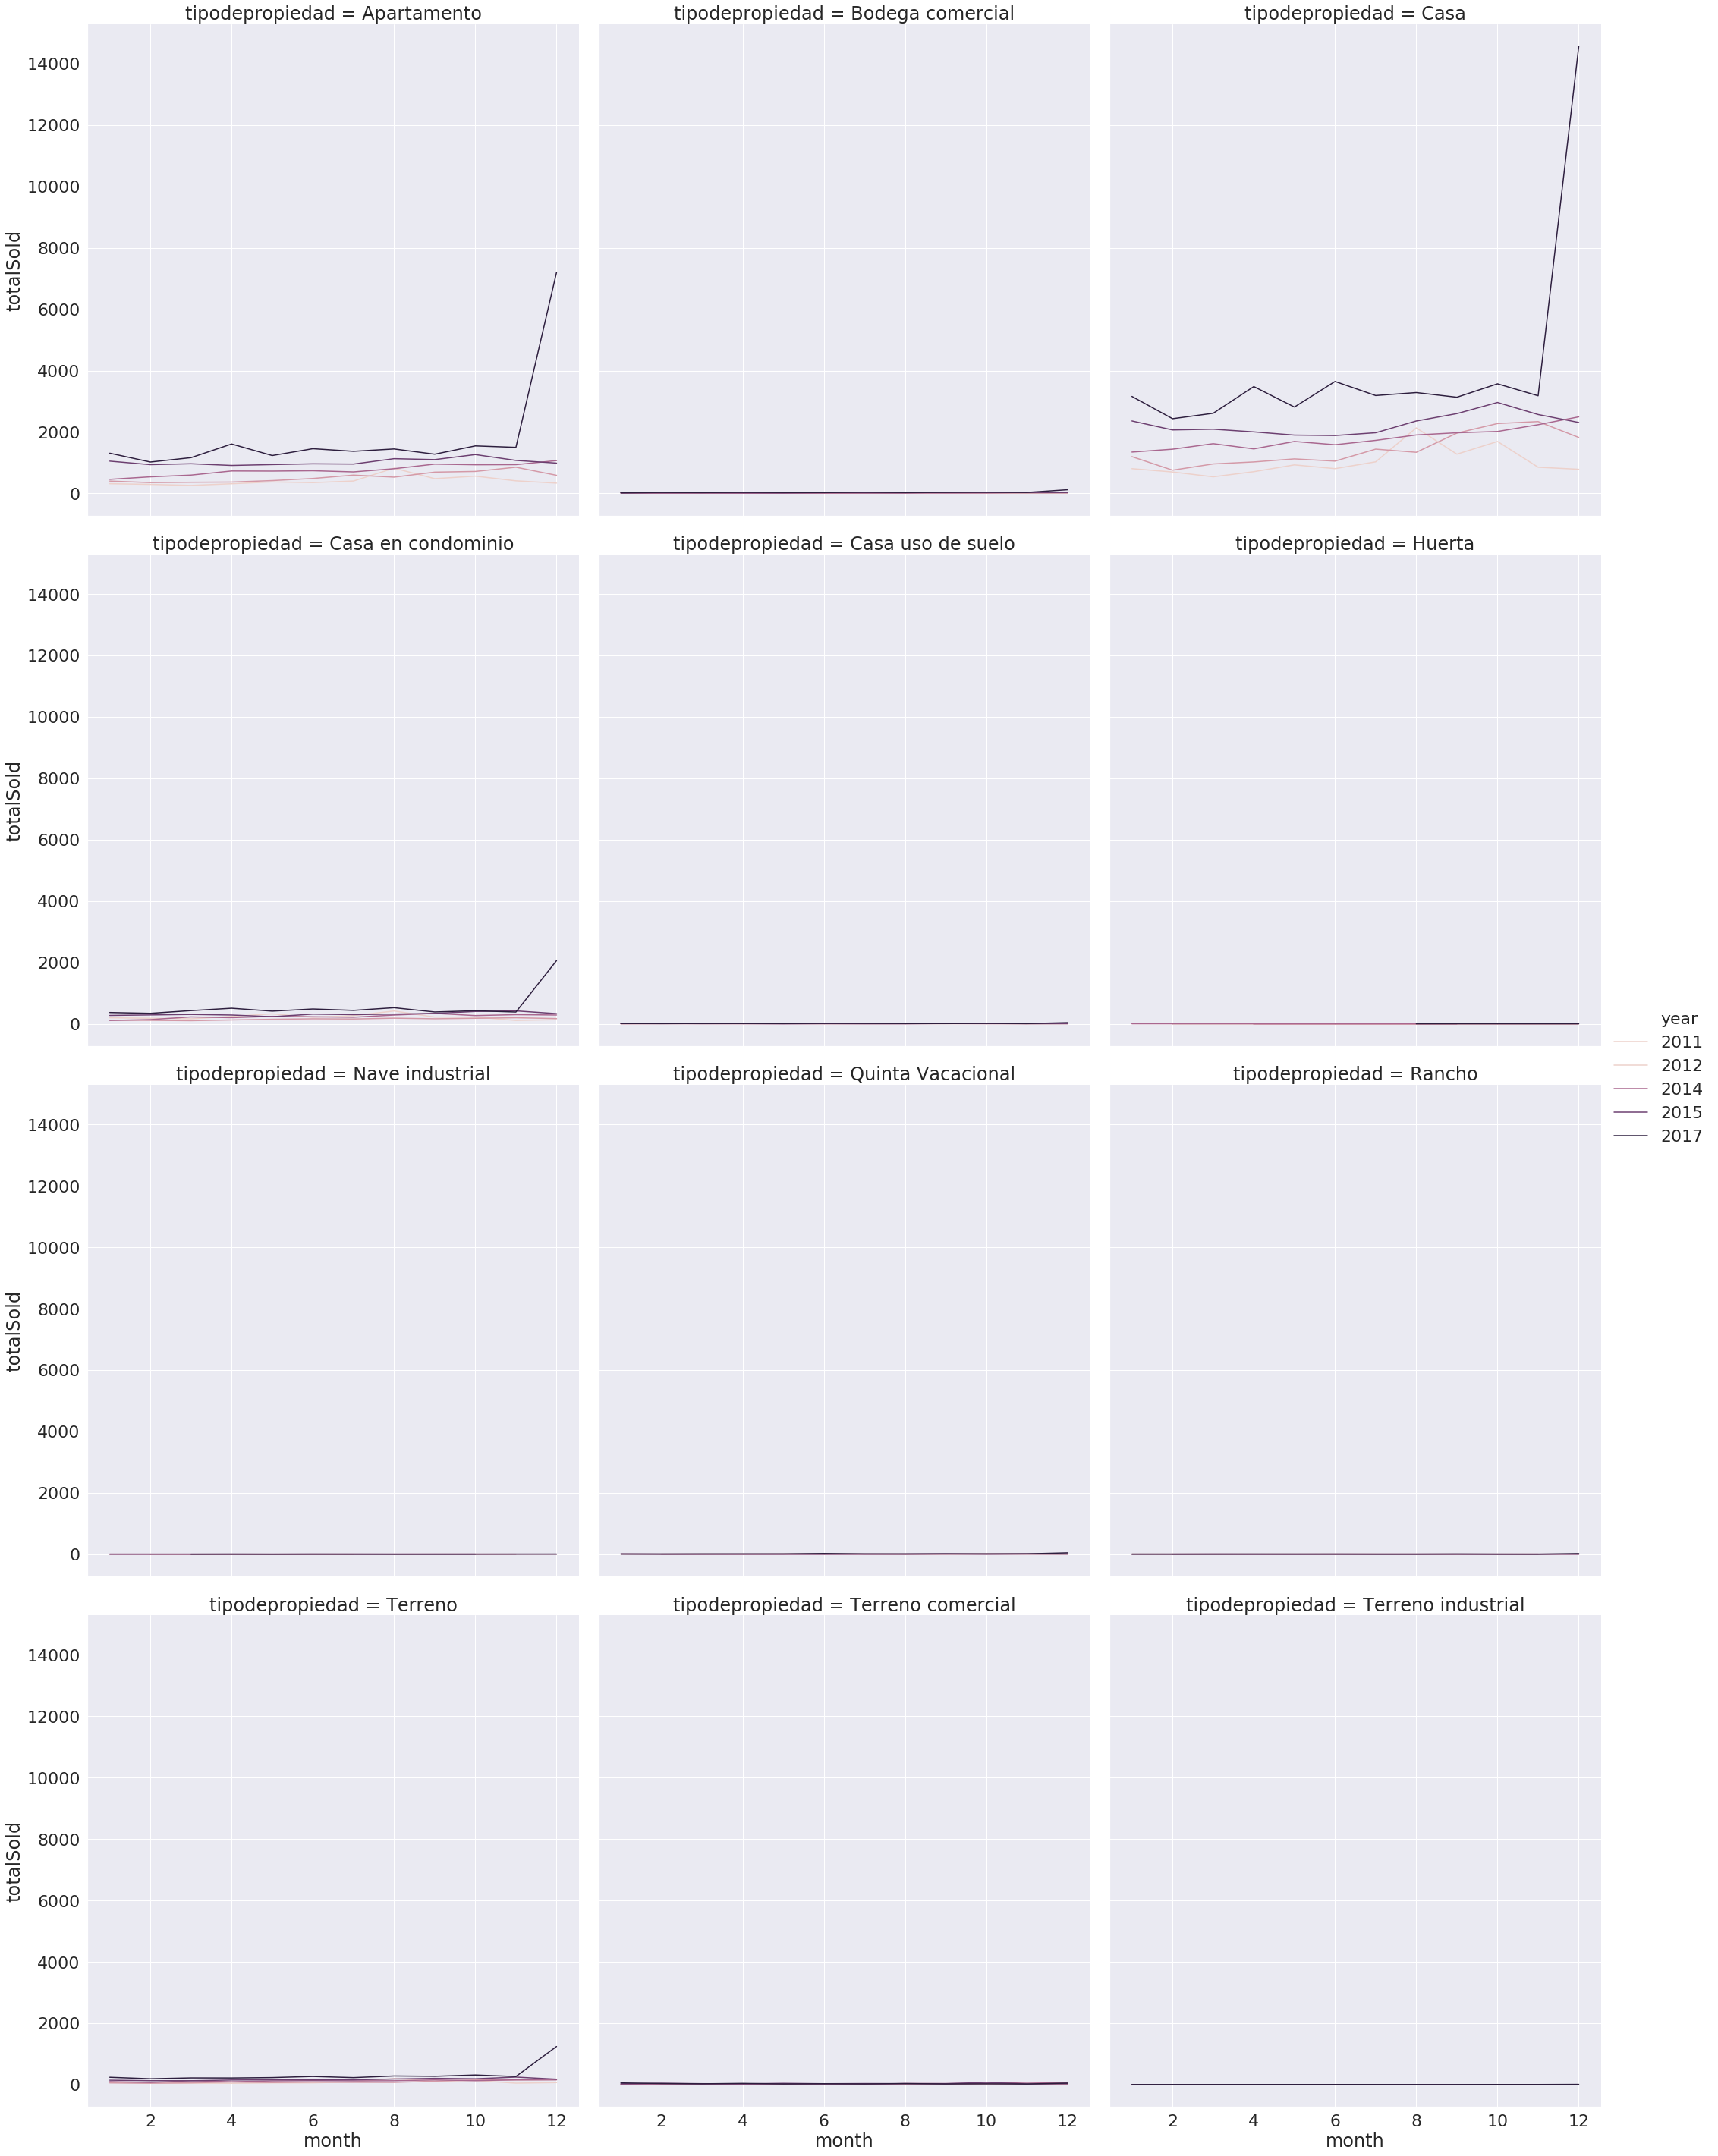

In [62]:
sns.set(font_scale=2)
sns.relplot(x="month", col_wrap=3,y='totalSold',kind='line', hue = "year", 
            data=plot,col='tipodepropiedad',height=10, aspect=1)

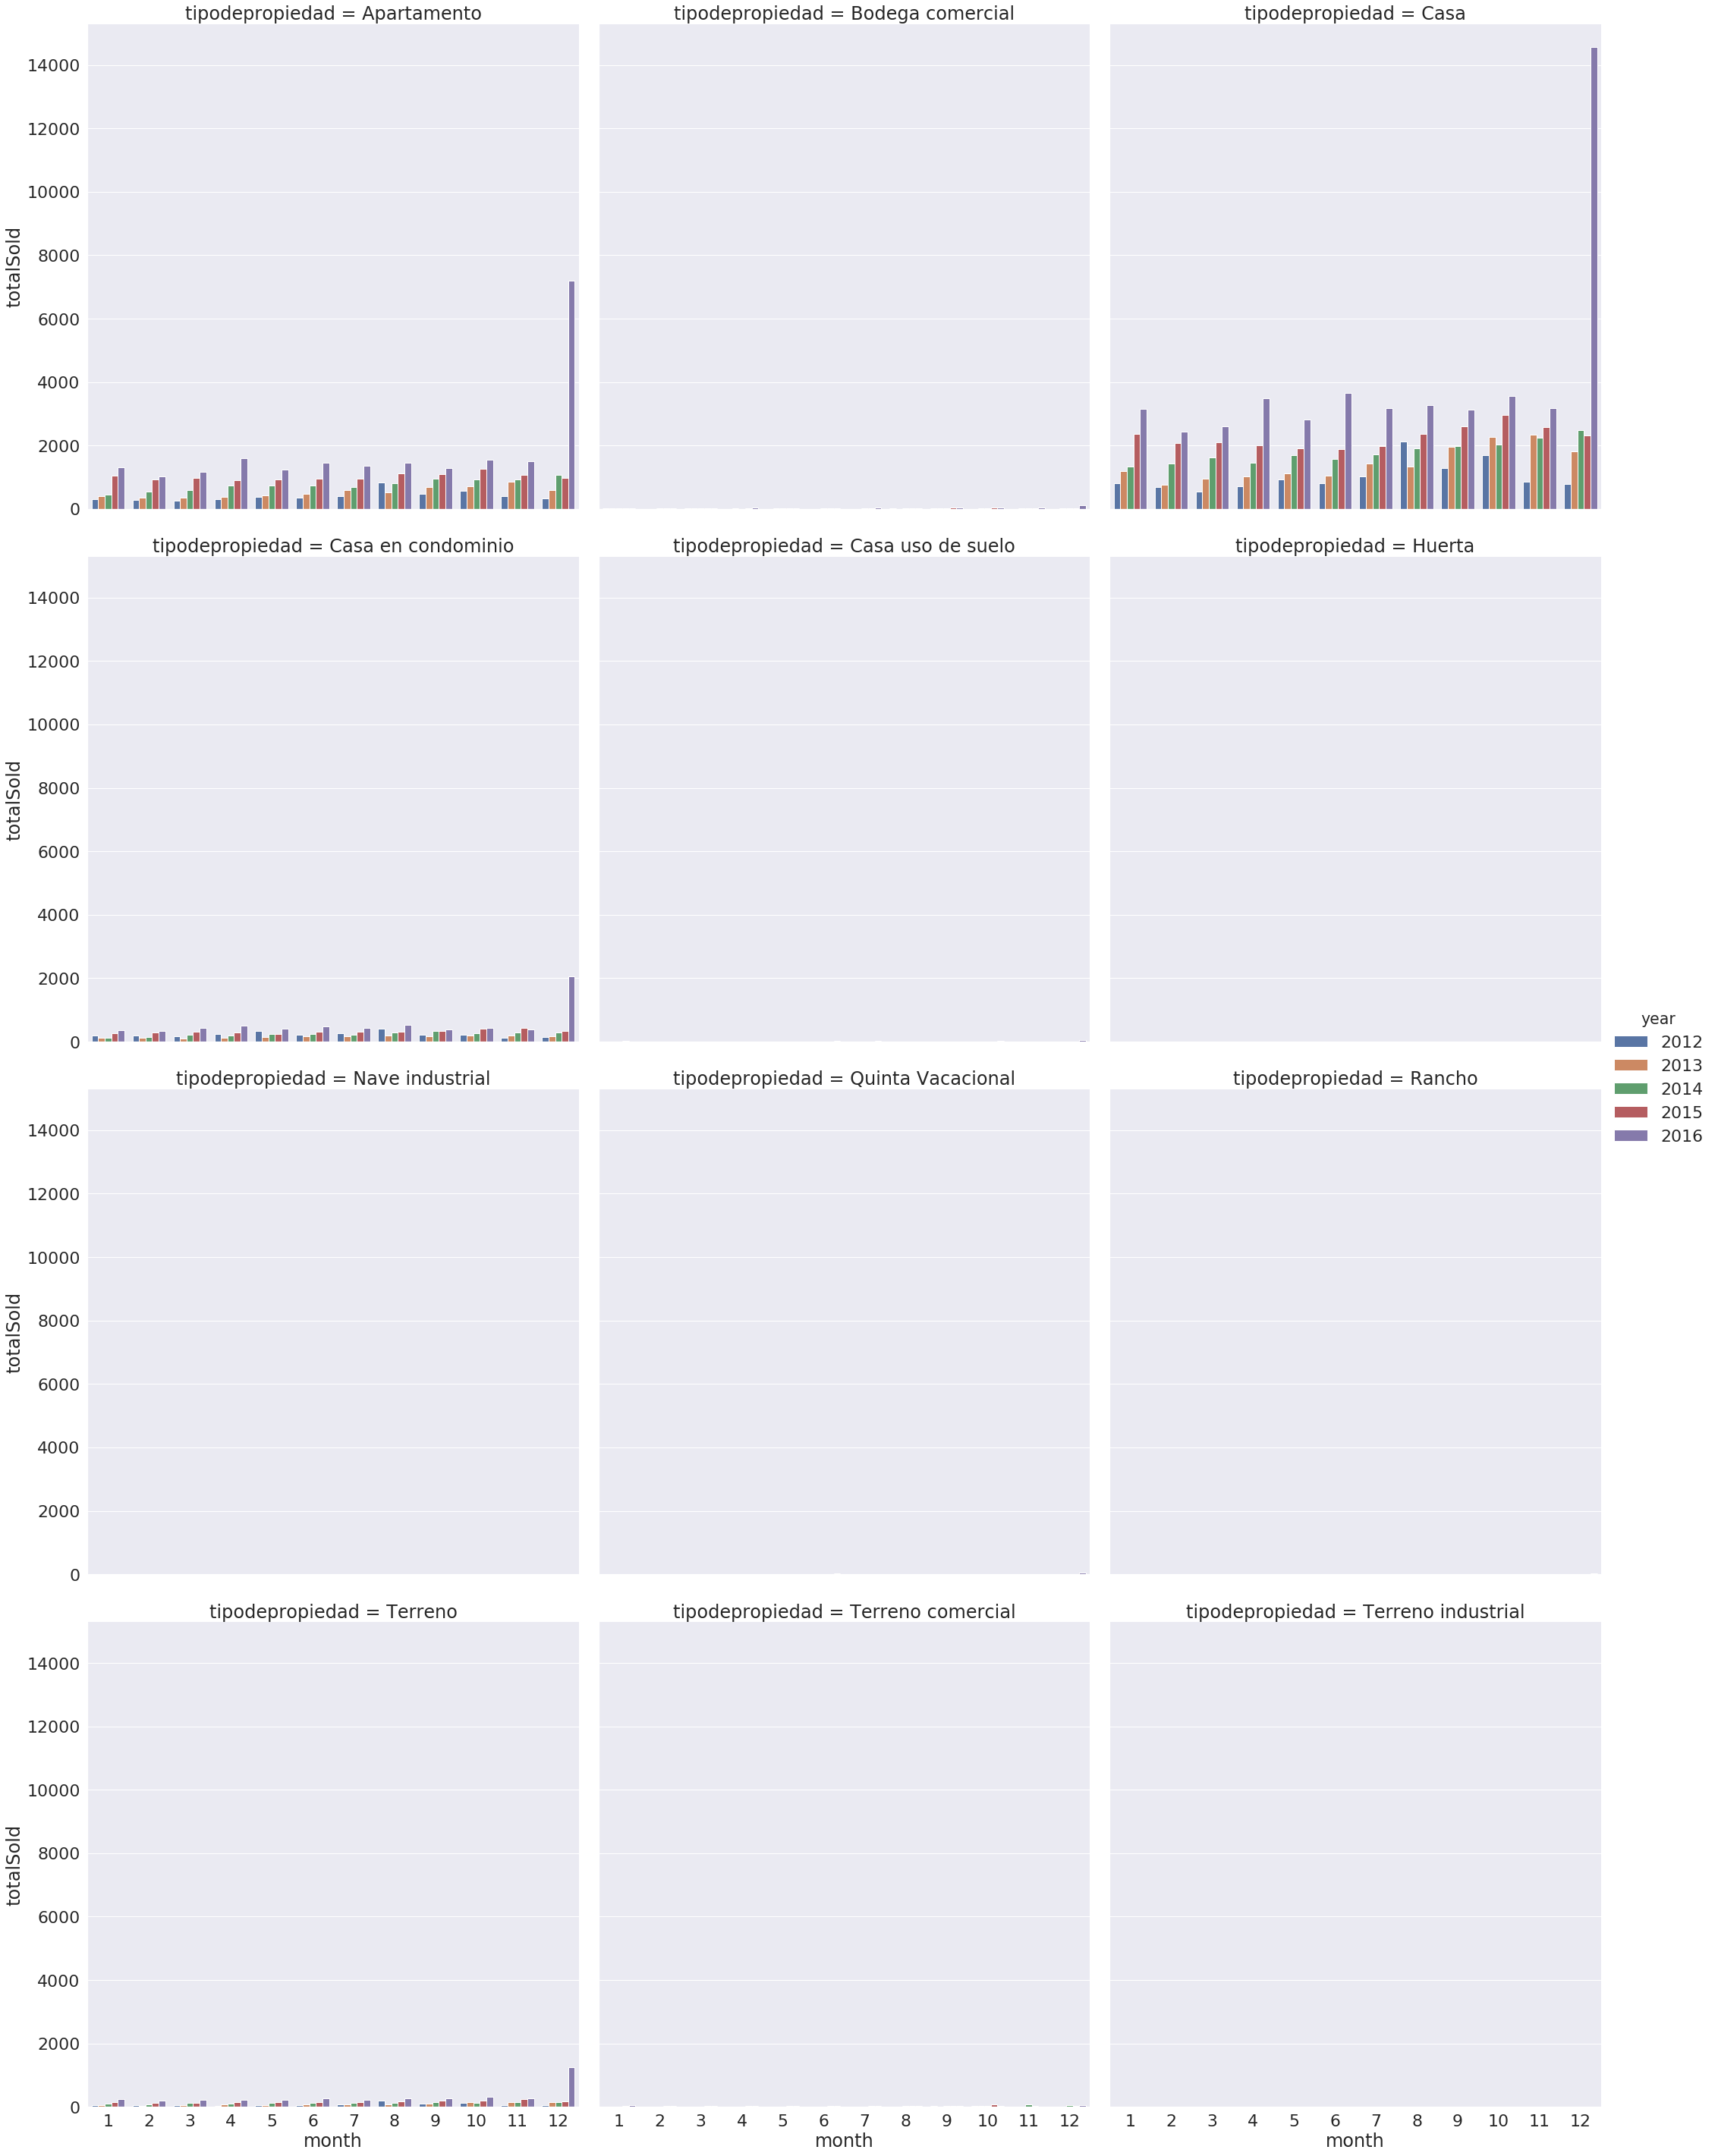

In [63]:
sns.catplot(x="month", col_wrap=3,y='totalSold',kind='bar', hue = "year", 
            data=plot,col='tipodepropiedad',height=10, aspect=1)

In [87]:
filter = plot["tipodepropiedad"].isin(["Apartamento", "Casa"])
plot1 = plot[filter]
plot1.tipodepropiedad.value_counts()

Casa           60
Apartamento    60
Name: tipodepropiedad, dtype: int64

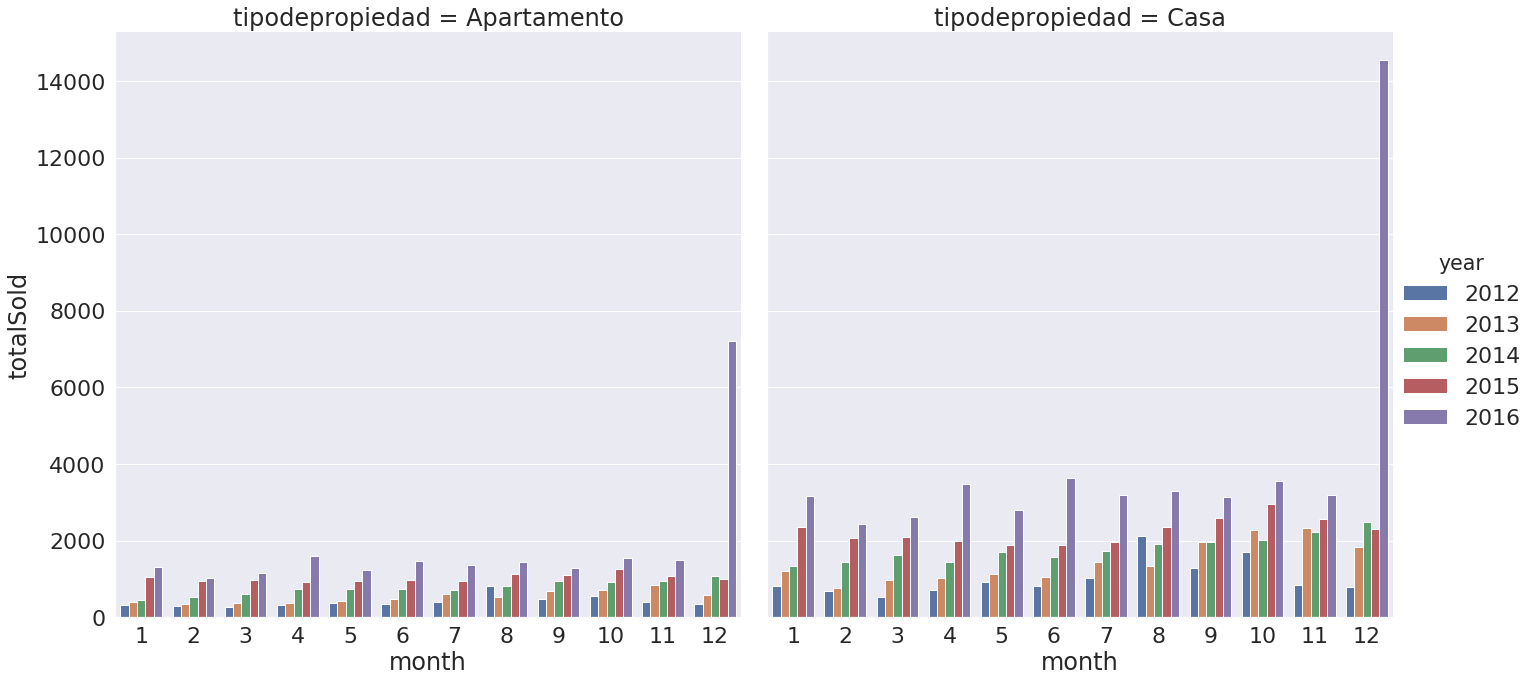

In [65]:
sns.catplot(x="month", col_wrap=2,y='totalSold',kind='bar', hue = "year", 
            data=plot1,col='tipodepropiedad',height=10, aspect=1)

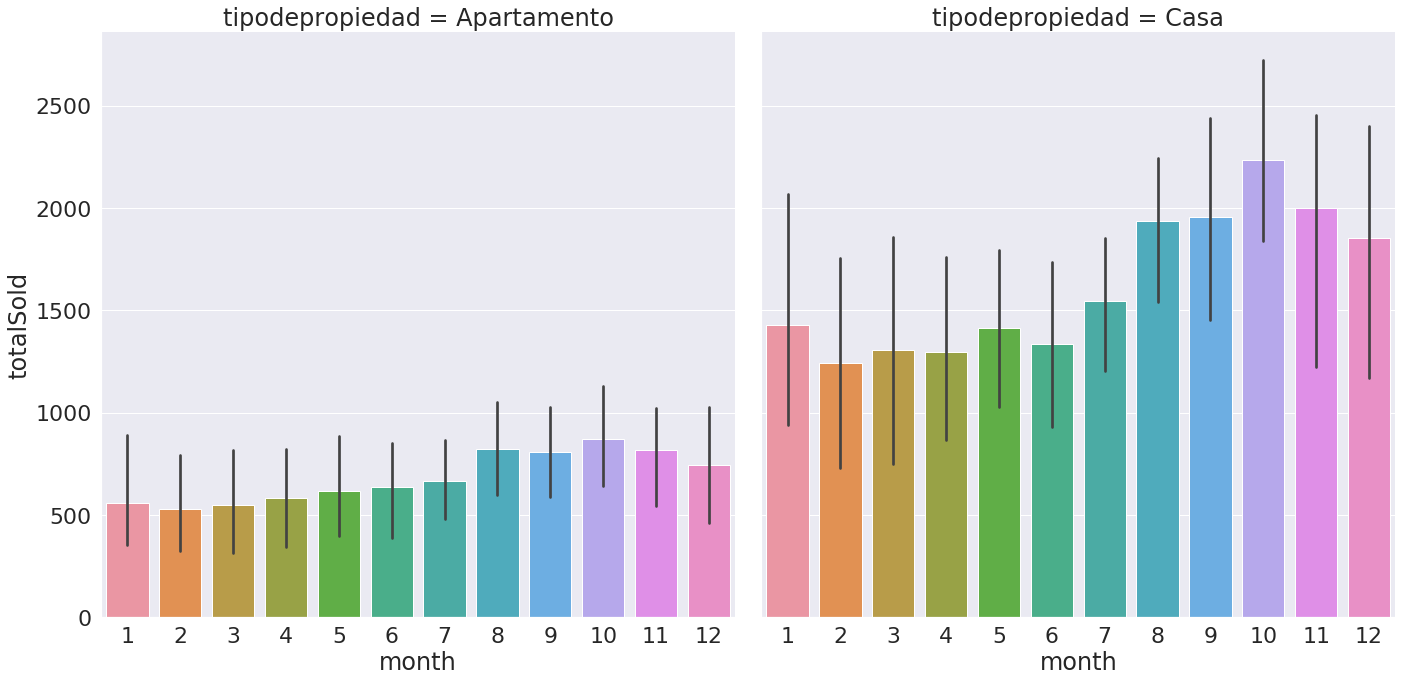

In [90]:
filter = plot1["year"].isin(["2012","2013","2014","2015"])
#Piso el mismo plot1
plot1 = plot1[filter]
sns.catplot(x="month", col_wrap=2,y='totalSold',kind='bar', 
            data=plot1,col='tipodepropiedad',height=10, aspect=1)

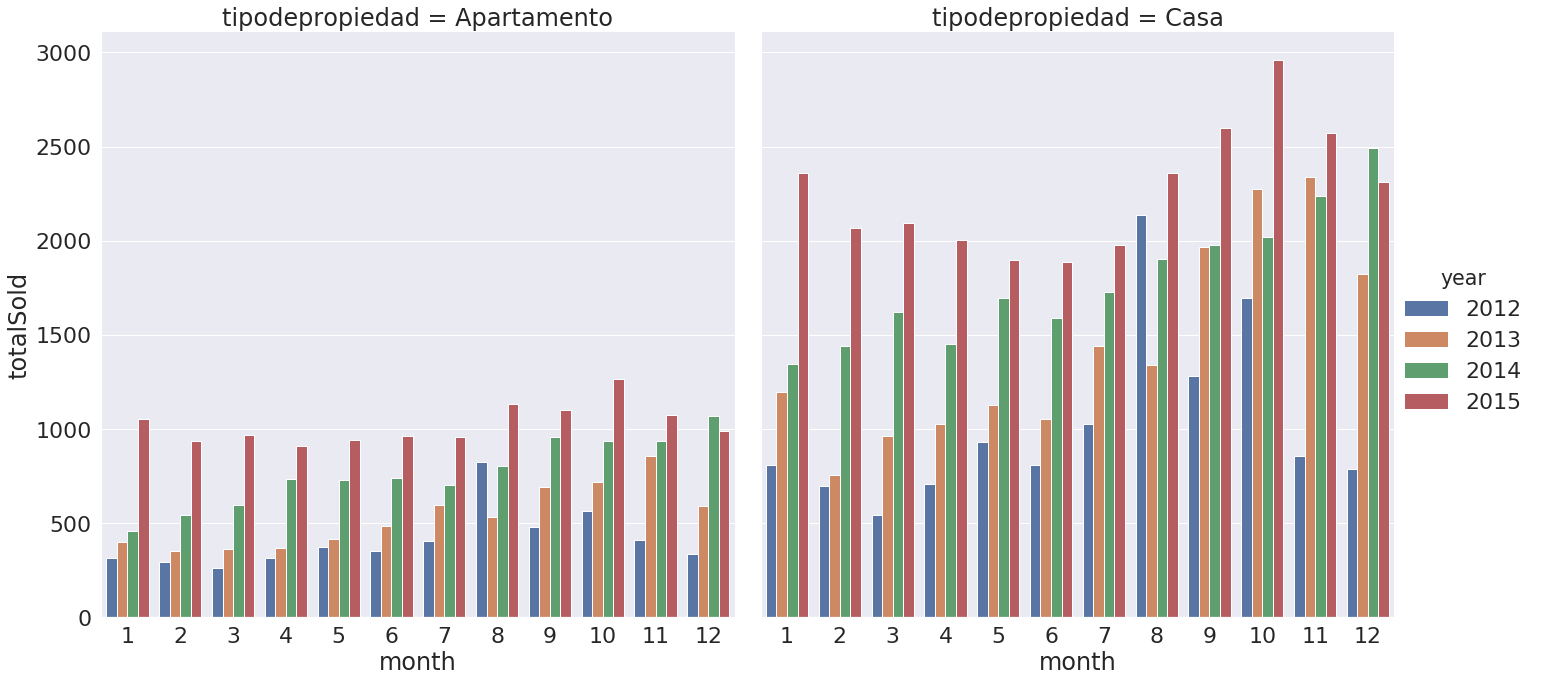

In [67]:
sns.catplot(x="month", col_wrap=2,y='totalSold', kind= "bar", hue="year",
            data=plot1,col='tipodepropiedad',height=10, aspect=1)

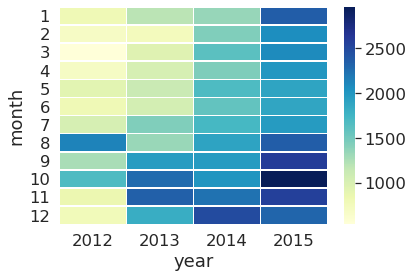

In [68]:
filtroCasas = plot1.tipodepropiedad.isin(["Casa"])
plotCasas = plot1[filtroCasas]
plotCasas = plotCasas.drop("tipodepropiedad", axis=1)
pivot = plotCasas.pivot("month", "year", "totalSold")
sns.set(font_scale=1.5)
ax = sns.heatmap(pivot, cmap="YlGnBu", linewidths=.5)

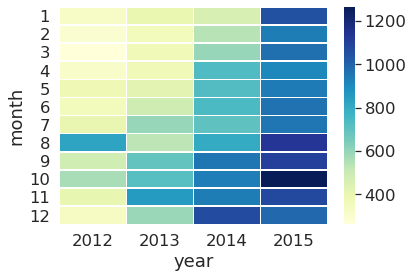

In [92]:
import matplotlib.pyplot as plt
filtroApartamento = plot1.tipodepropiedad.isin(["Apartamento"])
plotApartamento = plot1[filtroApartamento]
plotApartamento = plotApartamento.drop("tipodepropiedad", axis=1)
pivot = plotApartamento.pivot("month", "year", "totalSold")
sns.set(font_scale=1.5)
ax = sns.heatmap(pivot, cmap="YlGnBu", linewidths=.5)

In [93]:
plot.tipodepropiedad.value_counts()

Casa                  60
Terreno comercial     60
Terreno               60
Casa uso de suelo     60
Apartamento           60
Casa en condominio    60
Bodega comercial      60
Quinta Vacacional     54
Rancho                48
Nave industrial       36
Terreno industrial    14
Huerta                11
Name: tipodepropiedad, dtype: int64

In [84]:
plot2 = plot[plot.tipodepropiedad != "Casa"]
plot2 = plot2[plot2.tipodepropiedad != "Apartamento"]
plot2 = plot2[plot2.tipodepropiedad != "Casa en condominio"]
plot2 = plot2[plot2.tipodepropiedad != "Terreno"]
plot2.tipodepropiedad.value_counts()

Terreno comercial     60
Casa uso de suelo     60
Bodega comercial      60
Quinta Vacacional     54
Rancho                48
Nave industrial       36
Terreno industrial    14
Huerta                11
Name: tipodepropiedad, dtype: int64

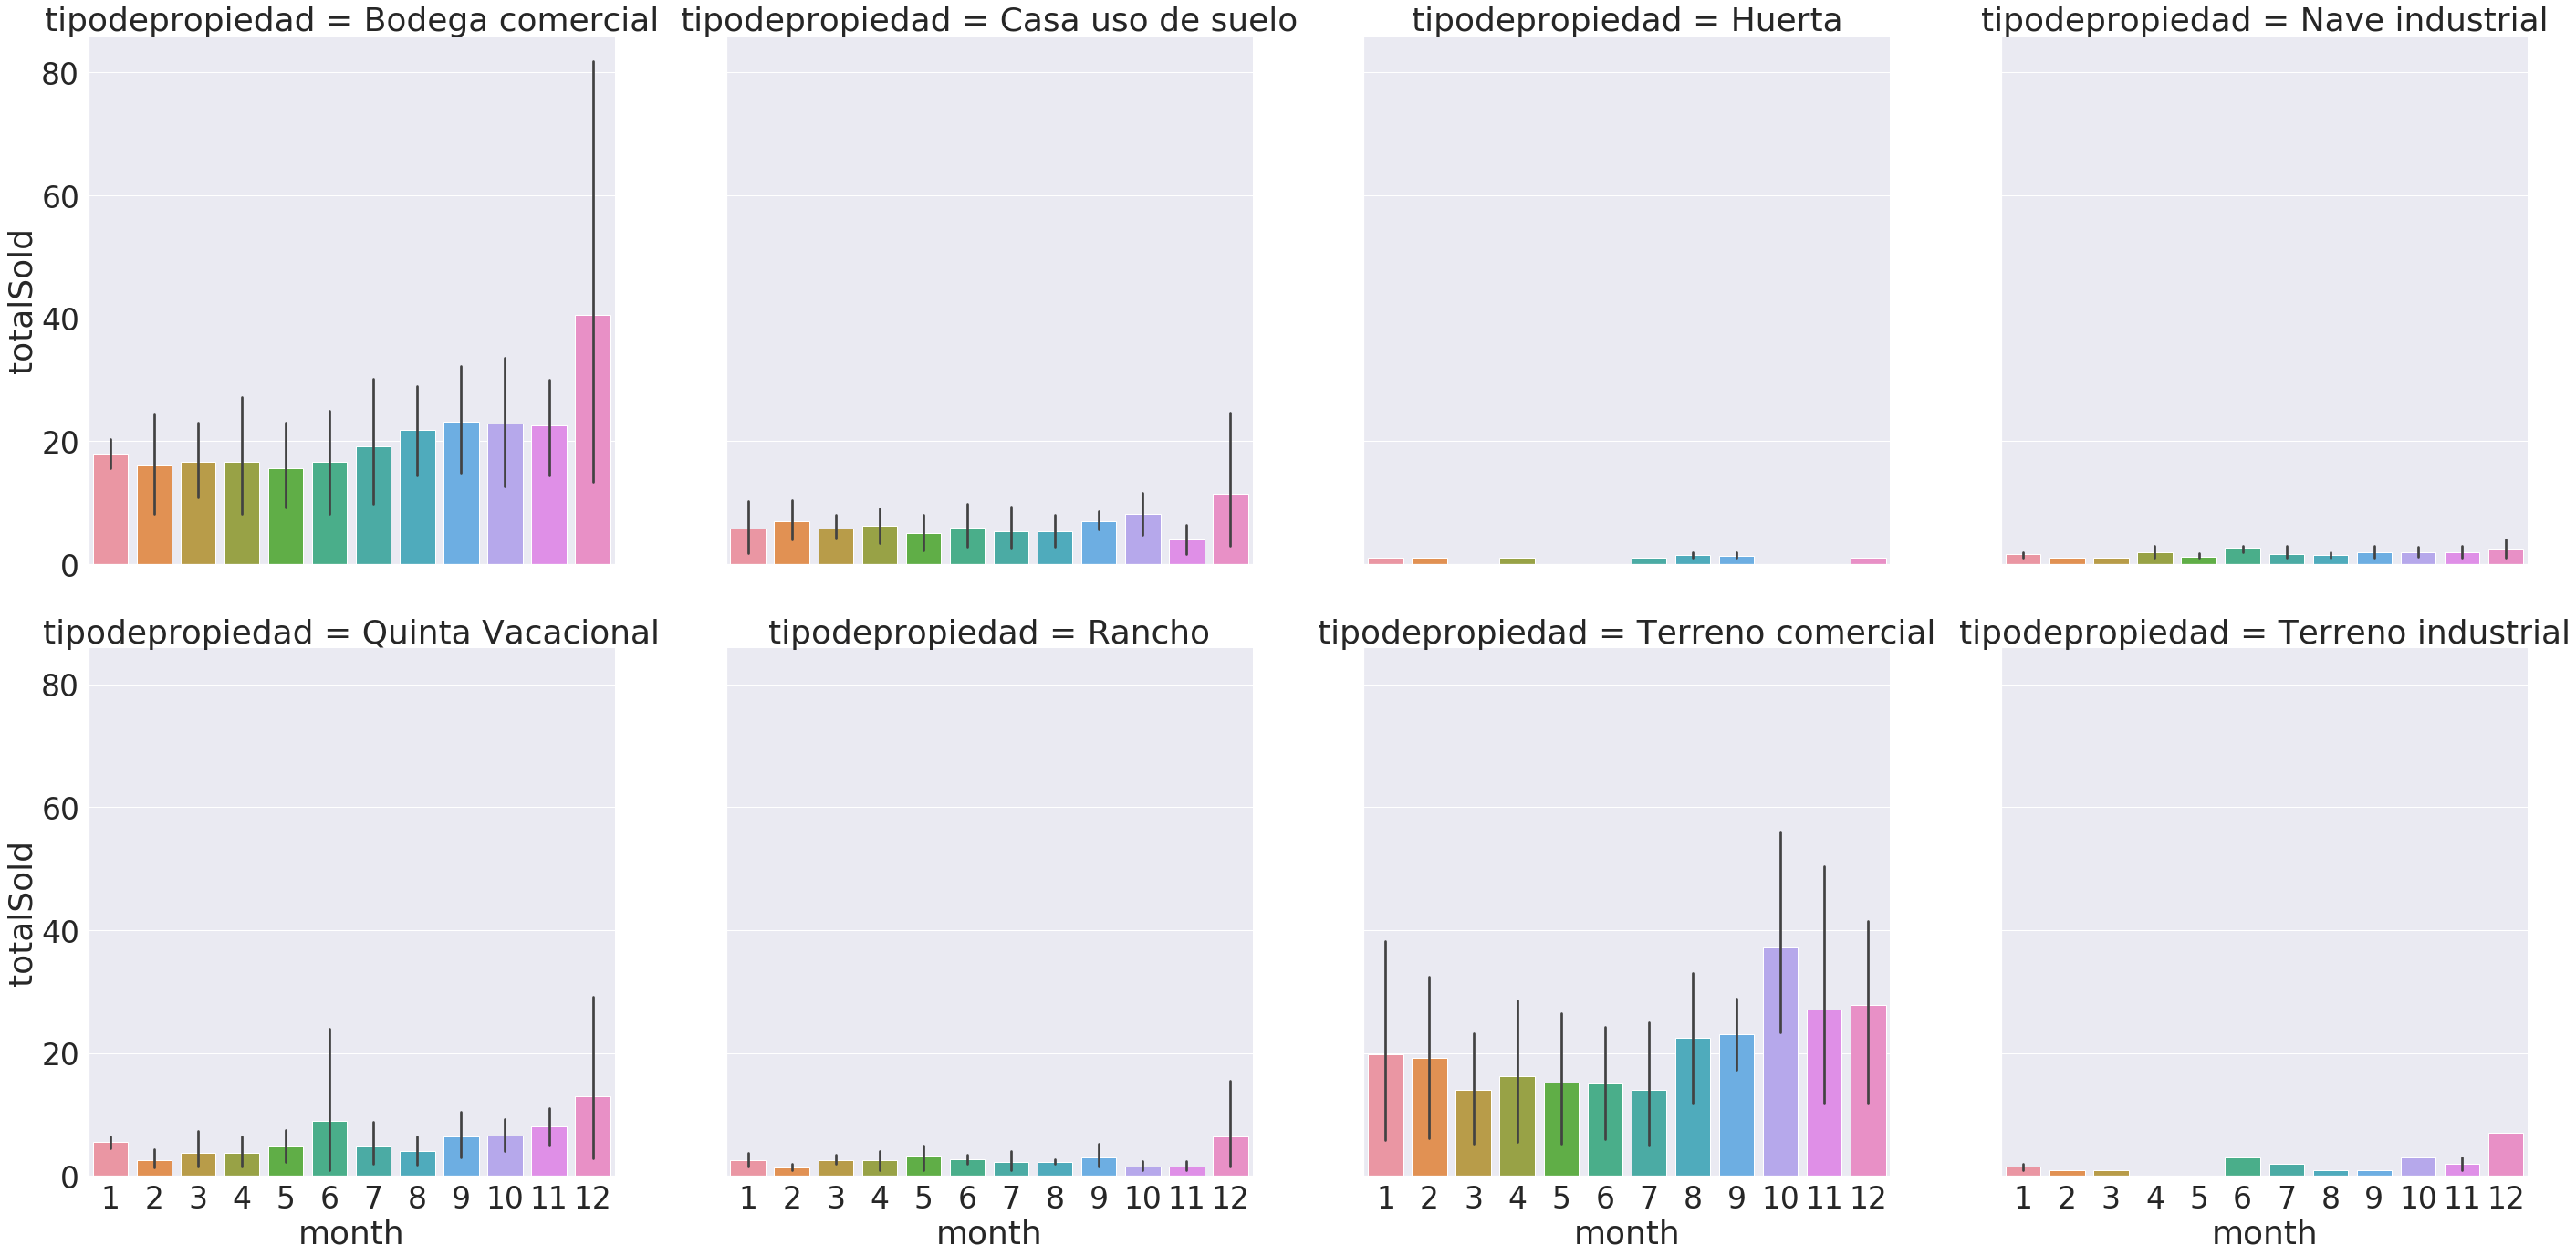

In [80]:
sns.set(font_scale=3)
sns.catplot(x="month", col_wrap=4,y='totalSold',kind='bar',
            data=plot2,col='tipodepropiedad',height=10, aspect=1)

In [83]:
filtroTC = plot2["tipodepropiedad"].isin(["Terreno","Casa en condominio"])
plotTC = plot2[filtroTC]
plotTC

,tipodepropiedad,year,month,totalSold


In [82]:
sns.set(font_scale=2)
sns.catplot(x="month", col_wrap=4,y='totalSold',kind='bar',
            data=plotTC,col='tipodepropiedad',height=10, aspect=1)

ValueError: min() arg is an empty sequence

In [ ]:
sns.catplot(x="month", col_wrap=2,y='totalSold',kind='bar', hue="year",
            data=plotTC,col='tipodepropiedad',height=10, aspect=1)

In [ ]:
filtroTC1215 = plotTC["year"].isin(["2012", "2013", "2014", "2015"])
plotTC1215 = plotTC[filtroTC1215]

In [ ]:
filtroCasaCondominio = plotTC1215["tipodepropiedad"].isin(["Casa en condominio"])
plotTC1215Casa = plotTC1215[filtroCasaCondominio]
plotTC1215Casa = plotTC1215Casa.drop("tipodepropiedad", axis=1)
pivot = plotTC1215Casa.pivot("month", "year", "totalSold")
sns.set(font_scale=1.5)
plt.figure(figsize=(20,15))
ax = sns.heatmap(pivot, cmap="YlGnBu", annot=True, linewidths=5, fmt='g')

In [ ]:
filtroTerreno = plotTC1215["tipodepropiedad"].isin(["Terreno"])
plotTC1215Terreno = plotTC1215[filtroTerreno]
plotTC1215Terreno = plotTC1215Terreno.drop("tipodepropiedad", axis=1)
pivot = plotTC1215Terreno.pivot("month", "year", "totalSold")
sns.set(font_scale=1.5)
plt.figure(figsize=(20,15))
ax = sns.heatmap(pivot, cmap="YlGnBu", annot=True, linewidths=5, fmt='g')

In [ ]:
sns.set(font_scale=3)
sns.catplot(x="month", col_wrap=4,y='totalSold',kind='bar', hue="year",
            data=plot2,col='tipodepropiedad',height=10, aspect=1)

In [ ]:
filtro3 = plot["tipodepropiedad"].isin(["Bodega comercial", "Casa uso de suelo", "Quinta Vacacional",
                                         "Terreno comecial"])
plot3 = plot[filtro3]
plot3.tipodepropiedad.value_counts()


In [ ]:
#Saco terreno y casa en condominio
plot2 = plot2[plot2.tipodepropiedad != "Terreno"]
plot2 = plot2[plot2.tipodepropiedad != "Casa en condominio"] 
sns.set_context
sns.catplot(x="month", col_wrap=2,y='totalSold',kind='bar',
            data=plot2,col='tipodepropiedad',height=10, aspect=1)
